In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datasets

/Users/amyguan/miniforge3/envs/weaver/lib/python3.11/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


# Load MATH500 Llama_3.1_70B_Instruct_v1 Dataset

In [2]:
# Load the MATH500 dataset from Hugging Face
dataset = datasets.load_dataset("hazyresearch/MATH500_with_Llama_3.1_70B_Instruct_v1")["data"]

print(f"Dataset loaded successfully!")
print(f"Number of problems: {len(dataset)}")
print(f"Dataset features: {dataset.features}")
print(f"\nFirst problem keys: {list(dataset[0].keys())}")

README.md: 0.00B [00:00, ?B/s]

data/data-00000-of-00001.parquet:   0%|          | 0.00/47.2M [00:00<?, ?B/s]

Generating data split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset loaded successfully!
Number of problems: 500
Dataset features: {'problem': Value('string'), 'solution': Value('string'), 'answer': Value('string'), 'subject': Value('string'), 'level': Value('int64'), 'unique_id': Value('string'), 'instruction': Value('string'), 'samples': List(Value('string')), 'extracted_answers': List(Value('string')), 'answer_correct': List(Value('bool')), 'DeepSeekLlama70B_verdicts': List(Value('float64')), 'DeepSeekQwen32B_verdicts': List(Value('float64')), 'Llama-3.3-70B-Instruct_verdicts': List(Value('float64')), 'Qwen/Qwen2.5-72B-Instruct_verdicts': List(Value('float64')), 'Mixtral-8x22B-Instruct-v0.1_verdicts': List(Value('float64')), 'Meta-Llama-3.1-405B-Instruct-quantized.w8a16_verdicts': List(Value('float64')), 'WizardLM-2-8x22B_verdicts': List(Value('float64')), 'SkyT1_verdicts': List(Value('float64')), 'GRM_scores': List(Value('float64')), 'Skyworks_scores': List(Value('float64')), 'URM_scores': List(Value('float64')), 'QRM_scores': List(Value('f

In [8]:
first_problem = dataset[0]

print(f"{first_problem['instruction'][:200]}...")
print(f"\nK={len(first_problem['samples'])}")
print(f"Percent correct={sum(first_problem['answer_correct']) / len(first_problem['samples']) * 100}%")

# Show verifier scores
verifier_columns = [col for col in first_problem.keys() if col.endswith('_scores')]
print(f"\nVerifier score columns: {verifier_columns[:10]}...")  # Show first 10


Problem: Suzanne walks four miles every third day. What is the fewest number of miles she can walk in February?

Please solve this step by step, then output your answer on a new line as 'The answer is...

K=100
Percent correct=87.0%

Verifier score columns: ['GRM_scores', 'Skyworks_scores', 'URM_scores', 'QRM_scores', 'GPM_scores', 'GRMLlama32_scores', 'OffsetBias_scores', 'GRMGemma_scores', 'ArmorRM_scores', 'QwenPRM_min_scores']...


In [21]:
# Extract all verifier score columns
verifier_columns = [col for col in dataset[0].keys() if col.endswith('_scores') and 'weaver' not in col]
print(f"Number of verifiers: {len(verifier_columns)}")

# Create a matrix to store all verifier scores across all problems
# Shape: (num_problems * K, num_verifiers)
all_scores = []
verifier_names = []

for col in verifier_columns:
    scores_for_verifier = []
    for problem in dataset:
        scores_for_verifier.extend(problem[col])
    all_scores.append(scores_for_verifier)
    verifier_names.append(col.replace('_scores', ''))

scores_matrix = np.array(all_scores).T  # Shape: (500*100, num_verifiers)

Number of verifiers: 27


## Correlations

In [22]:
# Method 1: Pearson Correlation Matrix
correlation_matrix = np.corrcoef(scores_matrix.T)

# Create a DataFrame for easier analysis
corr_df = pd.DataFrame(correlation_matrix, 
                       index=verifier_names, 
                       columns=verifier_names)

print("=== CORRELATION ANALYSIS ===")
print(f"Correlation matrix shape: {correlation_matrix.shape}")

# Find most correlated pairs (excluding self-correlation)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
upper_triangle = correlation_matrix[mask]
indices = np.where(mask)

# Get top 10 most correlated pairs
top_correlations = []
for i in range(len(indices[0])):
    row_idx, col_idx = indices[0][i], indices[1][i]
    corr_val = correlation_matrix[row_idx, col_idx]
    top_correlations.append((verifier_names[row_idx], verifier_names[col_idx], corr_val))

top_correlations.sort(key=lambda x: x[2], reverse=True)

print("\n=== TOP 10 MOST CORRELATED VERIFIER PAIRS ===")
for i, (v1, v2, corr) in enumerate(top_correlations[:10]):
    print(f"{i+1:2d}. {v1} ↔ {v2}: {corr:.4f}")


=== CORRELATION ANALYSIS ===
Correlation matrix shape: (27, 27)

=== TOP 10 MOST CORRELATED VERIFIER PAIRS ===
 1. QRM ↔ DecisionTreeReward8B: 0.9848
 2. QRMGemma ↔ DecisionTreeReward27B: 0.9784
 3. EurusPRMStage2_min ↔ EurusPRMStage2_avg: 0.9593
 4. QRMGemma ↔ DecisionTreeReward8B: 0.9519
 5. QRM ↔ QRMGemma: 0.9515
 6. QRMGemma ↔ SkyworksGemma: 0.9493
 7. EurusPRMStage1_max ↔ EurusPRMStage1_avg: 0.9478
 8. DecisionTreeReward8B ↔ DecisionTreeReward27B: 0.9445
 9. SkyworksGemma ↔ DecisionTreeReward27B: 0.9438
10. QRM ↔ DecisionTreeReward27B: 0.9404


In [23]:
# Find most orthogonal (least correlated) pairs
print("\n=== TOP 10 MOST ORTHOGONAL VERIFIER PAIRS ===")
orthogonal_pairs = [(v1, v2, corr) for v1, v2, corr in top_correlations]
orthogonal_pairs.sort(key=lambda x: abs(x[2]))  # Sort by absolute correlation (closest to 0)

for i, (v1, v2, corr) in enumerate(orthogonal_pairs[:10]):
    print(f"{i+1:2d}. {v1} ↔ {v2}: {corr:.4f}")



=== TOP 10 MOST ORTHOGONAL VERIFIER PAIRS ===
 1. EurusPRMStage1_max ↔ Qwen72B: -0.0034
 2. GRMGemma ↔ EurusPRMStage2_max: -0.0036
 3. QwenPRM_max ↔ EurusPRMStage1_max: 0.0054
 4. EurusPRMStage2_max ↔ InternLM2RewardModel: 0.0061
 5. QwenPRM_max ↔ LDLRewardGemma: 0.0074
 6. EurusPRMStage1_min ↔ EurusPRMStage1_max: 0.0089
 7. GRMLlama32 ↔ EurusPRMStage2_max: 0.0089
 8. EurusPRMStage2_max ↔ SkyworksGemma: 0.0094
 9. EurusPRMStage2_max ↔ InternLM2Reward7B: 0.0105
10. QwenPRM_avg ↔ EurusPRMStage1_max: -0.0115


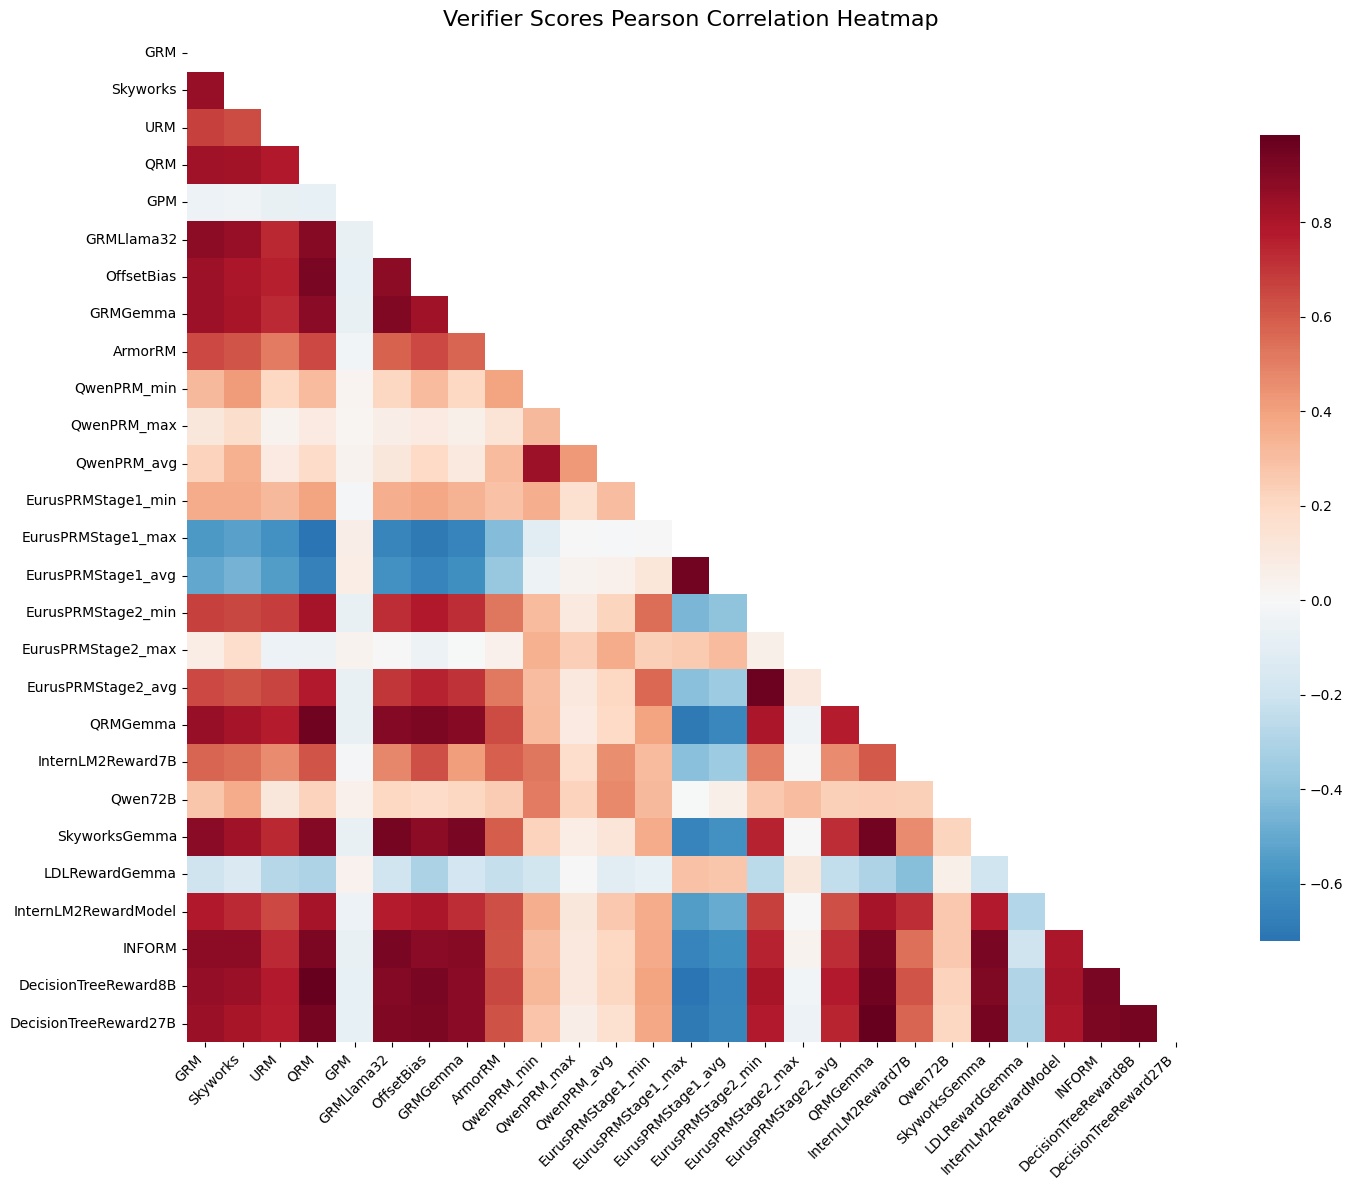

In [ ]:
# Visualization: Correlation Heatmap
plt.figure(figsize=(15, 12))

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot heatmap
sns.heatmap(correlation_matrix, 
            mask=mask,
            xticklabels=verifier_names,
            yticklabels=verifier_names,
            cmap='RdBu_r',
            center=0,
            square=True,
            cbar_kws={"shrink": .8},
            annot=False)

plt.title('Verifier Scores Pearson Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### todo: subset by RM, vs PRM, vs LMJudge?

In [25]:
# Method 2: Spearman Rank Correlation (for non-linear relationships)
from scipy.stats import spearmanr

spearman_corr_matrix = np.zeros_like(correlation_matrix)
for i in range(len(verifier_names)):
    for j in range(len(verifier_names)):
        spearman_corr_matrix[i, j], _ = spearmanr(scores_matrix[:, i], scores_matrix[:, j])

print(f"\nSpearman correlation matrix computed: {spearman_corr_matrix.shape}")


Spearman correlation matrix computed: (27, 27)


In [27]:
# Find most correlated pairs (excluding self-correlation)
mask = np.triu(np.ones_like(spearman_corr_matrix, dtype=bool), k=1)
upper_triangle = spearman_corr_matrix[mask]
indices = np.where(mask)

# Get top 10 most correlated pairs
top_correlations = []
for i in range(len(indices[0])):
    row_idx, col_idx = indices[0][i], indices[1][i]
    corr_val = spearman_corr_matrix[row_idx, col_idx]
    top_correlations.append((verifier_names[row_idx], verifier_names[col_idx], corr_val))

top_correlations.sort(key=lambda x: x[2], reverse=True)

# Find most orthogonal (least correlated) pairs
print("\n=== TOP 10 MOST ORTHOGONAL VERIFIER PAIRS ===")
orthogonal_pairs = [(v1, v2, corr) for v1, v2, corr in top_correlations]
orthogonal_pairs.sort(key=lambda x: abs(x[2]))  # Sort by absolute correlation (closest to 0)

for i, (v1, v2, corr) in enumerate(orthogonal_pairs[:10]):
    print(f"{i+1:2d}. {v1} ↔ {v2}: {corr:.4f}")


=== TOP 10 MOST ORTHOGONAL VERIFIER PAIRS ===
 1. QwenPRM_avg ↔ EurusPRMStage1_avg: 0.0011
 2. GPM ↔ GRMLlama32: -0.0019
 3. QwenPRM_max ↔ EurusPRMStage1_max: -0.0047
 4. GPM ↔ SkyworksGemma: -0.0093
 5. GPM ↔ INFORM: 0.0129
 6. GPM ↔ GRMGemma: -0.0137
 7. QwenPRM_max ↔ LDLRewardGemma: 0.0159
 8. GPM ↔ DecisionTreeReward27B: 0.0162
 9. URM ↔ GPM: 0.0228
10. EurusPRMStage1_max ↔ Qwen72B: 0.0231


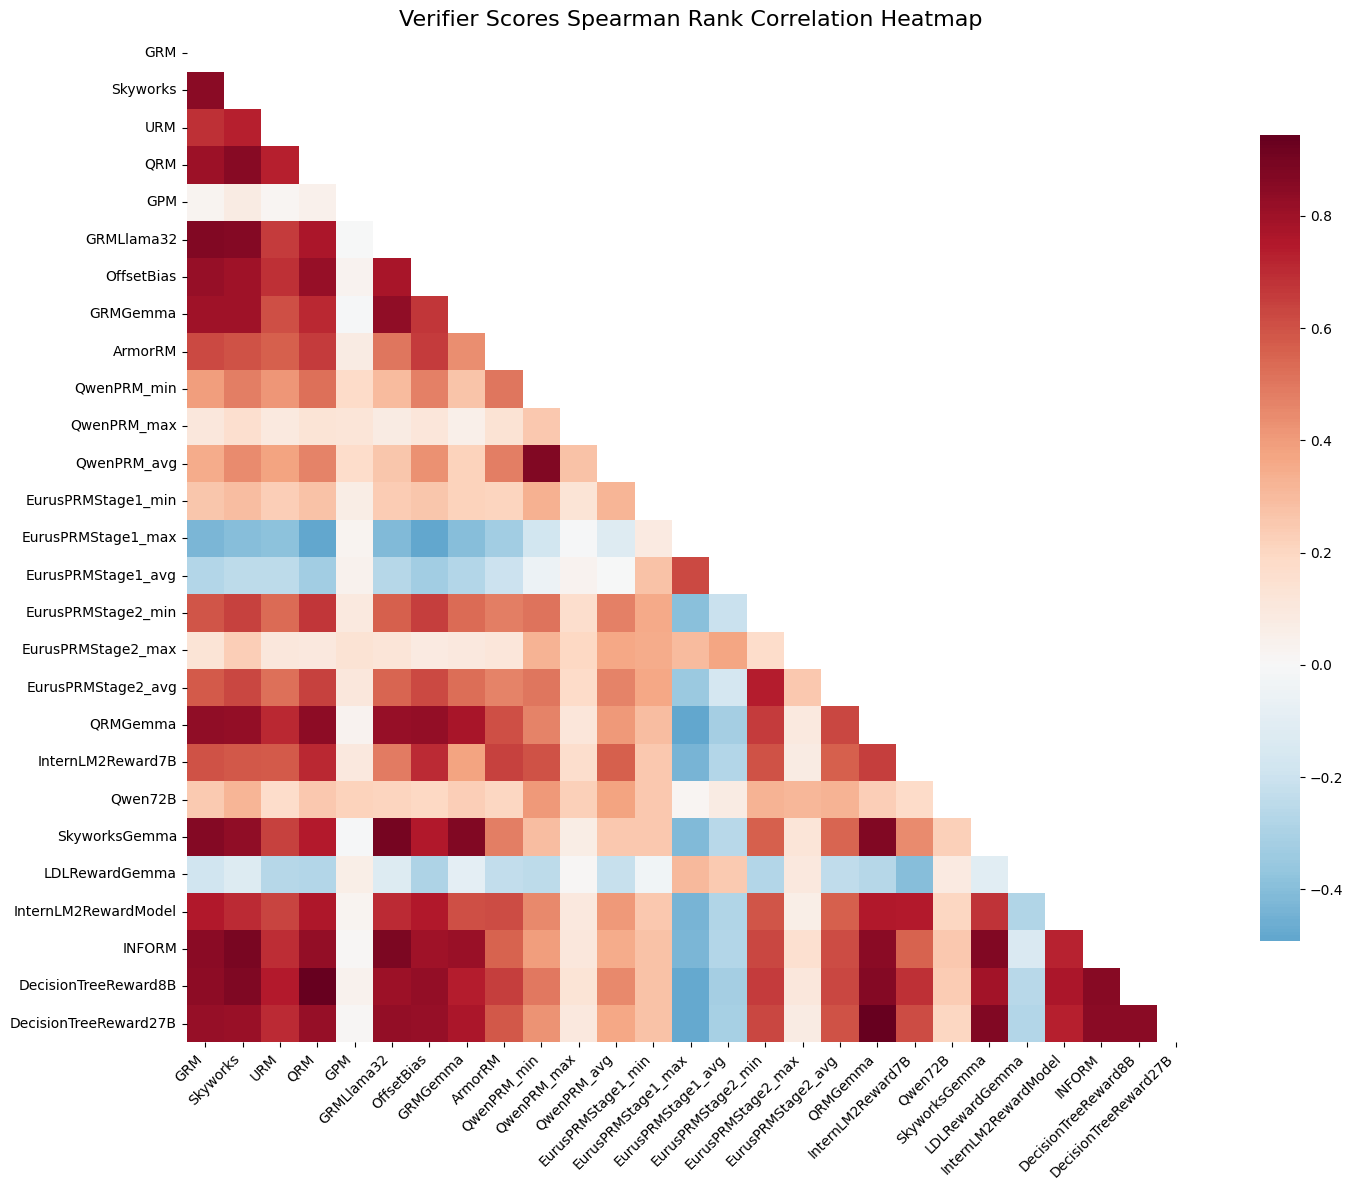

In [26]:
# Visualization: Correlation Heatmap
plt.figure(figsize=(15, 12))

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(spearman_corr_matrix, dtype=bool))

# Plot heatmap
sns.heatmap(spearman_corr_matrix, 
            mask=mask,
            xticklabels=verifier_names,
            yticklabels=verifier_names,
            cmap='RdBu_r',
            center=0,
            square=True,
            cbar_kws={"shrink": .8},
            annot=False)

plt.title('Verifier Scores Spearman Rank Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## PCA

In [28]:
# Method 3: Principal Component Analysis (PCA) for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
scores_scaled = scaler.fit_transform(scores_matrix)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(scores_scaled)

# Analyze explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print("=== PCA ANALYSIS ===")
print(f"First 10 components explain {cumulative_variance[9]:.3f} of variance")
print(f"First 5 components explain {cumulative_variance[4]:.3f} of variance")

# Show which verifiers contribute most to first few components
print("\n=== TOP CONTRIBUTORS TO FIRST 3 PRINCIPAL COMPONENTS ===")
for comp in range(3):
    component_loadings = pca.components_[comp]
    # Get indices of top contributors (by absolute value)
    top_indices = np.argsort(np.abs(component_loadings))[-5:][::-1]
    print(f"\nPC{comp+1} (explains {explained_variance_ratio[comp]:.3f} of variance):")
    for idx in top_indices:
        print(f"  {verifier_names[idx]}: {component_loadings[idx]:.4f}")


=== PCA ANALYSIS ===
First 10 components explain 0.915 of variance
First 5 components explain 0.799 of variance

=== TOP CONTRIBUTORS TO FIRST 3 PRINCIPAL COMPONENTS ===

PC1 (explains 0.550 of variance):
  DecisionTreeReward8B: 0.2531
  QRM: 0.2520
  QRMGemma: 0.2518
  DecisionTreeReward27B: 0.2494
  INFORM: 0.2462

PC2 (explains 0.113 of variance):
  QwenPRM_avg: 0.4525
  QwenPRM_min: 0.4213
  EurusPRMStage2_max: 0.3617
  Qwen72B: 0.3460
  EurusPRMStage1_avg: 0.2820

PC3 (explains 0.056 of variance):
  LDLRewardGemma: 0.4192
  InternLM2Reward7B: -0.3583
  EurusPRMStage1_min: 0.3283
  EurusPRMStage1_avg: 0.3116
  EurusPRMStage1_max: 0.2876


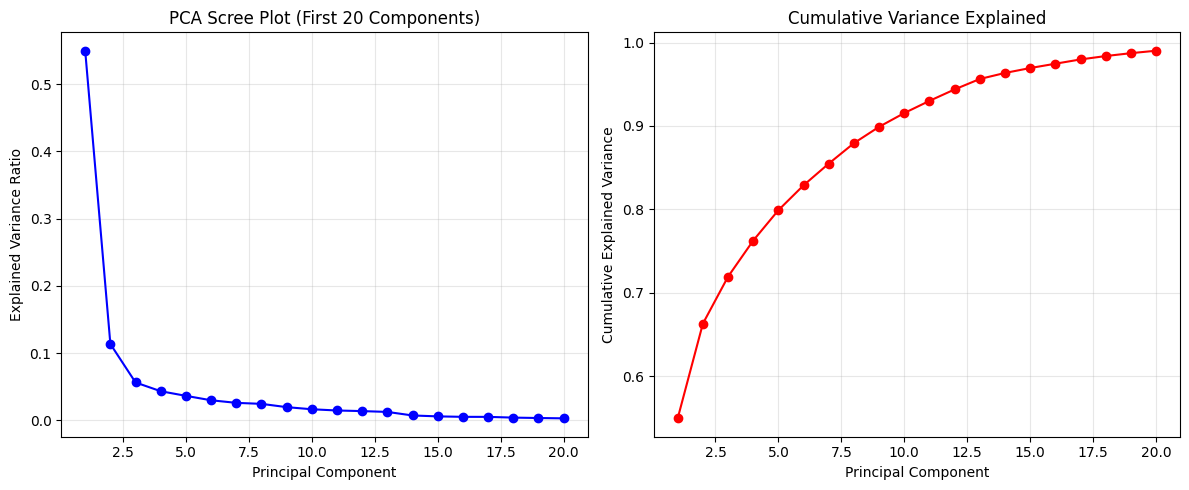

In [29]:
# Visualization: PCA Scree Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 21), explained_variance_ratio[:20], 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Scree Plot (First 20 Components)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, 21), cumulative_variance[:20], 'ro-')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance Explained')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Hierarchical Clustering

In [30]:
# Method 4: Hierarchical Clustering to group similar verifiers
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# Convert correlation matrix to distance matrix
distance_matrix = 1 - np.abs(correlation_matrix)
np.fill_diagonal(distance_matrix, 0)

# Perform hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='ward')

print("=== HIERARCHICAL CLUSTERING ===")
print("Clustering completed. Use the dendrogram to visualize verifier groups.")

# Method 5: Mutual Information (for non-linear dependencies)
from sklearn.feature_selection import mutual_info_regression

# Calculate mutual information between each pair
mi_matrix = np.zeros((len(verifier_names), len(verifier_names)))
for i in range(len(verifier_names)):
    for j in range(len(verifier_names)):
        if i != j:
            mi_matrix[i, j] = mutual_info_regression(
                scores_matrix[:, i].reshape(-1, 1), 
                scores_matrix[:, j]
            )[0]

print(f"Mutual information matrix computed: {mi_matrix.shape}")


ValueError: Distance matrix 'X' must be symmetric.

In [ ]:
# Visualization: Dendrogram for Hierarchical Clustering
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, 
           labels=verifier_names,
           orientation='top',
           leaf_rotation=45,
           leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram', fontsize=16)
plt.xlabel('Verifiers')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()


In [31]:
# Summary Analysis: Verifier Diversity Score
def calculate_diversity_score(corr_matrix, verifier_idx):
    """Calculate how orthogonal a verifier is to all others"""
    correlations = corr_matrix[verifier_idx, :]
    correlations = np.delete(correlations, verifier_idx)  # Remove self-correlation
    return 1 - np.mean(np.abs(correlations))  # Higher score = more orthogonal

diversity_scores = []
for i in range(len(verifier_names)):
    diversity_scores.append(calculate_diversity_score(correlation_matrix, i))

# Create summary DataFrame
summary_df = pd.DataFrame({
    'Verifier': verifier_names,
    'Diversity_Score': diversity_scores,
    'Mean_Correlation': [np.mean(np.abs(correlation_matrix[i, :])) for i in range(len(verifier_names))]
})

summary_df = summary_df.sort_values('Diversity_Score', ascending=False)

print("=== VERIFIER DIVERSITY ANALYSIS ===")
print("Higher diversity score = more orthogonal to other verifiers")
print("\nTop 10 Most Diverse (Orthogonal) Verifiers:")
print(summary_df.head(10)[['Verifier', 'Diversity_Score']].to_string(index=False))

print("\nTop 10 Least Diverse (Most Correlated) Verifiers:")
print(summary_df.tail(10)[['Verifier', 'Diversity_Score']].to_string(index=False))


=== VERIFIER DIVERSITY ANALYSIS ===
Higher diversity score = more orthogonal to other verifiers

Top 10 Most Diverse (Orthogonal) Verifiers:
          Verifier  Diversity_Score
               GPM         0.943214
EurusPRMStage2_max         0.883772
       QwenPRM_max         0.879965
    LDLRewardGemma         0.788825
           Qwen72B         0.770234
       QwenPRM_avg         0.760459
       QwenPRM_min         0.689401
EurusPRMStage1_min         0.688193
EurusPRMStage1_avg         0.575358
 InternLM2Reward7B         0.548981

Top 10 Least Diverse (Most Correlated) Verifiers:
             Verifier  Diversity_Score
             Skyworks         0.416104
                  GRM         0.412059
           GRMLlama32         0.405168
        SkyworksGemma         0.396630
               INFORM         0.382260
           OffsetBias         0.378793
DecisionTreeReward27B         0.373532
             QRMGemma         0.364855
                  QRM         0.363142
 DecisionTreeReward8B 

In [ ]:
## Model Selection: Balancing Diversity vs Utility

# First, let's create ground truth labels for utility assessment
# We'll use the answer_correct labels as our target
ground_truth = []
for problem in dataset:
    ground_truth.extend(problem['answer_correct'])

ground_truth = np.array(ground_truth)
print(f"Ground truth shape: {ground_truth.shape}")
print(f"Overall accuracy: {np.mean(ground_truth):.3f}")

# Calculate individual verifier utility (AUC-ROC)
from sklearn.metrics import roc_auc_score

individual_utilities = []
for i in range(len(verifier_names)):
    try:
        auc = roc_auc_score(ground_truth, scores_matrix[:, i])
        individual_utilities.append(auc)
    except:
        individual_utilities.append(0.5)  # Default for perfect correlation

print(f"Individual verifier utilities (AUC-ROC) calculated")

Ground truth shape: (50000,)
Overall accuracy: 0.780
Individual verifier utilities (AUC-ROC) calculated
